### 문자 메시지의 스팸 여부 예측
### UCI 머신러닝 저장소 - SMS 스팸 데이터셋 

#### import library

In [1]:
import os
import re
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from zipfile import ZipFile 

In [2]:
epochs = 20
batch_size = 250
max_sequenc_length = 25
rnn_size = 10
embedding_size = 50
min_word_frequency = 10
learning_rate = 0.0005
dropout_keep_prob = tf.placeholder(tf.float32)

#### 데이터 준비

In [3]:
data_dir = 'temp'
data_file = 'text_data.txt'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
if not os.path.isfile(os.path.join(data_dir, data_file)):
    ziq_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(ziq_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    text_data = file.decode()
    text_data = text_data.encode('ascii', errors = 'ignore')
    text_data = text_data.decode().split('\n')
    
    with open(os.path.join(data_dir, data_file), 'w') as file_conn:
        for text in text_data:
            file_conn.write("{}\n".format(text))
else:
    text_data =[]
    with open(os.path.join(data_dir, data_file), 'r') as file_conn:
        for row in file_conn:
            text_data.append(row)
    text_data = text_data[:-1]
    
text_data = [x.split('\t') for x in text_data if len(x)>=1]
[text_data_target, text_data_train] = [list(x) for x in zip(*text_data)]

#### 소문자 변환, 특수 문자 및 부가 공백 제거 

In [4]:
def clean_text(text_string):
    text_string = re.sub(r'([^\s\w]|_|[0-9])+', '', text_string)
    text_string = " ".join(text_string.split())
    text_string = text_string.lower()
    return (text_string)

text_data_train = [clean_text(x) for x in text_data_train]

#### 문자데이터에 대한 색인 리스트

단어가 25개 이상인 문자는 잘라내고 10회 이상 등장하는 단어만 어휘 사전에 등록

In [5]:
vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_sequenc_length, min_word_frequency)
 
text_processed = np.array(list(vocab_processor.fit_transform(text_data_train)))

#### 데이터 셔플

In [6]:
text_processed = np.array(text_processed)

text_data_target = np.array([1 if x=='ham' else 0 for x in text_data_target])

shuffled_ix = np.random.permutation(np.arange(len(text_data_target)))

x_shuffled = text_processed[shuffled_ix]
y_shuffled = text_data_target[shuffled_ix]

#### train, test set 분리

In [21]:
ix_cutoff = int(len(y_shuffled)* 0.80)
x_train, x_test = x_shuffled[:ix_cutoff], x_shuffled[ix_cutoff:]
y_train, y_test = y_shuffled[:ix_cutoff], y_shuffled[ix_cutoff:]

vocab_size = len(vocab_processor.vocabulary_)

print("Vocabulary size : {:d}".format(vocab_size))

Vocabulary size : 934


#### 플레이스 홀더 선언 x : [None, max_sequence_length]

In [8]:
x_data = tf.placeholder(tf.int32, [None, max_sequenc_length])
y_output = tf.placeholder(tf.int32, [None])

#### 임베딩 행렬 생성, 임베딩 값을 조회하는 연산 생성

In [9]:
embedding_mat = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0))

embedding_output = tf.nn.embedding_lookup(embedding_mat, x_data)

#### 모델 생성


In [10]:
cell = tf.contrib.rnn.BasicRNNCell(num_units=rnn_size)

output, state = tf.nn.dynamic_rnn(cell, embedding_output, dtype=tf.float32)

output = tf.nn.dropout(output, dropout_keep_prob)

output = tf.transpose(output, [1,0,2])

last = tf.gather(output, int(output.get_shape()[0]) -1)

In [15]:
weight = tf.Variable(tf.truncated_normal([rnn_size,2], stddev=0.1))
bias = tf.Variable(tf.constant(0.1, shape=[2]))
logits_out = tf.nn.softmax(tf.matmul(last, weight) + bias)

#### loss 함수 생성
sparse_softmax 함수를 사용할 때는 정수 색인 값과 실수형 로짓 값이 필요

In [16]:
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_out, labels=y_output)
#logit = float32, labels = int32
loss = tf.reduce_mean(losses)

#### accuracy

In [17]:
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits_out,1), tf.cast(y_output,tf.int64)), tf.float32))

#### optimizer, 모델변수 초기화

In [19]:
optimizer = tf.train.RMSPropOptimizer(learning_rate)
train_step = optimizer.minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


#### 학습

In [22]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):
    
    #학습데이터 셔플
    shuffled_ix = np.random.permutation(np.arange(len(x_train)))
    x_train = x_train[shuffled_ix]
    y_train = y_train[shuffled_ix]
    num_batches = int(len(x_train)/batch_size) + 1
    
    for i in range(num_batches):
        
        #학습데이터 선택
        min_ix = i*batch_size
        max_ix = np.min([len(x_train), ((i+1) * batch_size)])
        x_train_batch = x_train[min_ix:max_ix]
        y_train_batch = y_train[min_ix:max_ix]
        
        #학습 실행
        train_dict = {x_data : x_train_batch, y_output : y_train_batch, dropout_keep_prob : 0.5}
        sess.run(train_step, feed_dict=train_dict)
        
    #학습 loss, accuracy
    temp_train_loss, temp_train_acc = sess.run([loss, accuracy], feed_dict=train_dict)
    train_loss.append(temp_train_loss)
    train_accuracy.append(temp_train_acc)
    
    #평가
    test_dict = {x_data : x_test, y_output : y_test, dropout_keep_prob : 1.0}
    temp_test_loss, temp_test_acc = sess.run([loss, accuracy], feed_dict=test_dict)
    test_loss.append(temp_test_loss)
    test_accuracy.append(temp_test_acc)
    
    print ('Epoch : {}, Test Loss : {:.2}, Test Acc : {:.2}'.format(epoch +1, temp_test_loss, temp_test_acc))

Epoch : 1, Test Loss : 0.65, Test Acc : 0.83
Epoch : 2, Test Loss : 0.63, Test Acc : 0.83
Epoch : 3, Test Loss : 0.61, Test Acc : 0.83
Epoch : 4, Test Loss : 0.58, Test Acc : 0.83
Epoch : 5, Test Loss : 0.56, Test Acc : 0.83
Epoch : 6, Test Loss : 0.54, Test Acc : 0.84
Epoch : 7, Test Loss : 0.52, Test Acc : 0.84
Epoch : 8, Test Loss : 0.51, Test Acc : 0.84
Epoch : 9, Test Loss : 0.5, Test Acc : 0.84
Epoch : 10, Test Loss : 0.49, Test Acc : 0.84
Epoch : 11, Test Loss : 0.48, Test Acc : 0.84
Epoch : 12, Test Loss : 0.48, Test Acc : 0.85
Epoch : 13, Test Loss : 0.47, Test Acc : 0.85
Epoch : 14, Test Loss : 0.47, Test Acc : 0.86
Epoch : 15, Test Loss : 0.47, Test Acc : 0.86
Epoch : 16, Test Loss : 0.46, Test Acc : 0.86
Epoch : 17, Test Loss : 0.46, Test Acc : 0.86
Epoch : 18, Test Loss : 0.46, Test Acc : 0.86
Epoch : 19, Test Loss : 0.46, Test Acc : 0.86
Epoch : 20, Test Loss : 0.46, Test Acc : 0.86


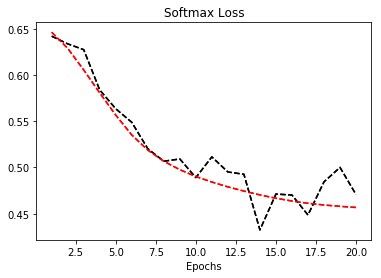

In [25]:
epoch_seq = np.arange(1, epochs+1)
plt.plot(epoch_seq, train_loss, 'k--', label = 'Train Set')
plt.plot(epoch_seq, test_loss, 'r--', label = 'Test Set')
plt.title('Softmax Loss')
plt.xlabel('Epochs')
plt.show()